# Principal Component Analysis, PCA (Exercise 21)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("axes", titlesize=16)
plt.rc("font", size=12)
from scipy.spatial.distance import pdist,squareform
from scipy.optimize import fmin
from matplotlib.colors import to_rgba

### Make your PCA

In [3]:
#THIS IS MY OWN CLASS THAT I MADE FOR CLUSTERING.IPYNB

class PCA():

    def __init__(self, X):
        self.X = X  #
        self.mu = np.mean(X, axis=0)  
        self.mu_T = self.mu.reshape(1, -1)  
        self.M = X.shape[0]  

    def mean_centering(self):
        # center the data by subtracting the mean of each variable
        one_M = np.ones((self.M, 1))  
        X_centered = self.X - one_M @ self.mu_T  
        return X_centered
    
    def covariance_matrix(self):
        # describes how the variables are correlated with each other
        X_centered = self.mean_centering()
        X_centered_T = X_centered.T
        C = 1/(self.M-1)*X_centered_T @ X_centered
        return C
    
    def eigval_decomp(self):
        C = self.covariance_matrix()
        eigenvalues, eigenvectors = np.linalg.eig(C)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        Lambda = np.diag(eigenvalues)
        return eigenvectors, Lambda
    
    def principal_components(self):
        X_centered = self.mean_centering()
        Q, _ = self.eigval_decomp(self)
        Z = X_centered @ Q
        return Z
    
    def dim_reduc(self, k):
        X_centered = self.mean_centering()
        Q, _ = self.eigval_decomp(self) 
        Q_k = Q[:, :k]
        Z_k = X_centered @ Q_k
        return Z_k
    
    def fit(self):
        # Compute mean-centered data
        self.X_centered = self.mean_centering()
        
        # Compute covariance matrix
        self.C = self.covariance_matrix()
        
        # Perform eigenvalue decomposition
        self.Q, self.Lambda = self.eigval_decomp()

    
    def transform(self, k):
        # Select the first k eigenvectors
        Q_k = self.Q[:, :k]
        
        # Project the mean-centered data onto the k principal components
        Z_k = self.X_centered @ Q_k
        return Z_k
    
    def inverse_transform(self, Z_k):
        # OPTIONALLY ADDED METHOD
        # Select the first k eigenvectors
        Q_k = self.Q[:, :Z_k.shape[1]]
        
        # Reconstruct the original data
        X_reconstructed = Z_k @ Q_k.T + self.mu
        return X_reconstructed



### Test on nonsense data

In [7]:
data_original = np.array([[2.5, 2.4],
              [2.0, 1.0],
              [2.2, 2.9],
              [1.4, 2.2],
              [1.1, 0.9]])
pca = PCA(data_original)
pca.fit()
data_transformed = pca.transform(k=2)
print(data_transformed)

[[-0.75606986 -0.36654926]
 [ 0.72170723 -0.52833576]
 [-1.07479405  0.12172822]
 [-0.09565016  0.53558477]
 [ 1.20480684  0.23757204]]


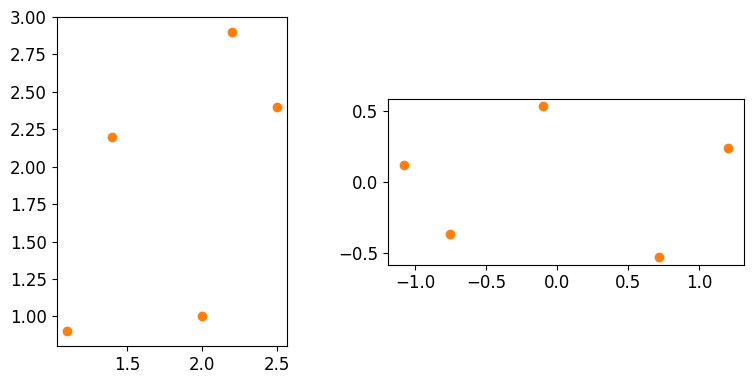

In [8]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

for ax, data in zip(axes,[data_original,data_transformed]):
    ax.scatter(data[:,0],data[:,1],c='C1')
    ax.set_aspect('equal')
    
fig.tight_layout()
#fig.savefig('exercise_21_fig1.png')

### Test on atomic cluster (using its cartesian coordinates)

In [5]:
from week4 import LennardJones, AtomicCluster
lennard_jones_calc = LennardJones()

In [9]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions_in_file = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)
positions_original = positions_in_file[30]
pca.fit(positions_original)
positions_transformed = pca.transform(positions_original)

FileNotFoundError: lj10clusters.txt not found.

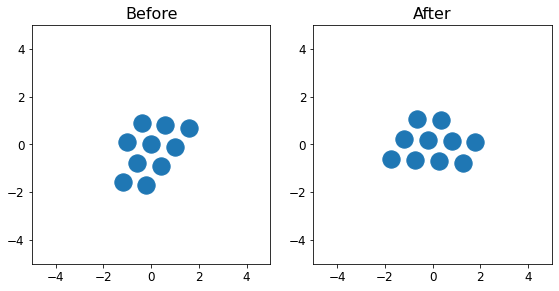

In [20]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

for ax, data, title in zip(axes,[positions_original,positions_transformed],
                              ['Before','After']):
    ax.scatter(data[:,0],data[:,1],s=300)
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_aspect('equal')
    ax.set_title(title)

fig.tight_layout()
#fig.savefig('exercise_21_fig2.png')

### Use your PCA on atomic clusters using their descriptors

In [8]:
class CoulombMatrixSpectrum():
    
    def __init__(self, color='C4'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos):
        r_matrix = squareform(pdist(pos))
        np.fill_diagonal(r_matrix, 1)
        one_over_r_matrix = r_matrix**-1
        eigen_values, _ = np.linalg.eig(one_over_r_matrix)
        eigen_values = np.real(eigen_values) # ignore any small complex component
        sorted_eigen_values = sorted(eigen_values)
        return sorted_eigen_values

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([-2,8])
        ax.set_title(self.__class__.__name__)
    
descriptor = CoulombMatrixSpectrum()

In [ ]:
def make_plot(filename,clusters,color='C0'):

    fig, axes = plt.subplots(2, 4, figsize=(12,6))
    for i,cluster in enumerate(clusters[:4]):
        row = i//2
        col = 2*(i%2)
        ax = axes[row,col]
        ring_size = 400
        cluster.draw(ax,ring_size,alpha=0.8,edge=True,color=color)
        
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_aspect('equal')
        ax.set_xlim([-b,b])
        ax.set_ylim([-b,b])
        ax.grid('on')
        
        ax = axes[row,col+1]
            
        cluster.descriptor_method = descriptor
        cluster.draw_descriptor(ax)
    
    fig.tight_layout()
    #fig.savefig(filename)


NameError: name 'cluster' is not defined

In [10]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions_in_file = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)


b = 4
    
atomic_clusters = [AtomicCluster(lennard_jones_calc,pos=pos,
                                 descriptor_method=descriptor)\
            for pos in positions_in_file]


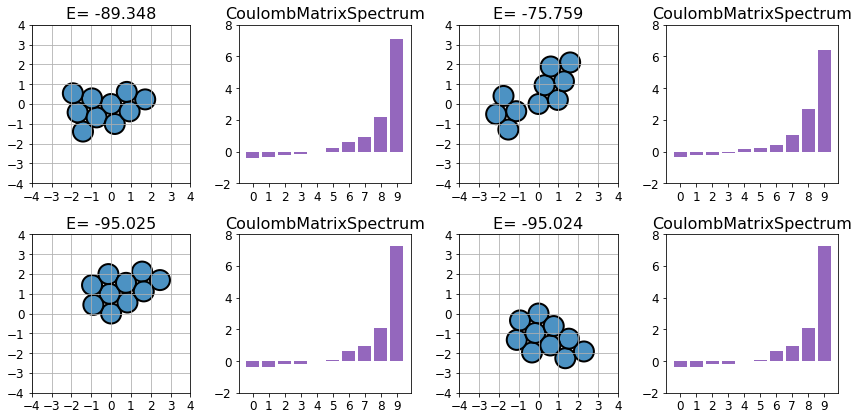

In [11]:
make_plot('exercise_21_fig3.png',atomic_clusters)

In [12]:
descriptors_original = np.array([cluster.descriptor for cluster in atomic_clusters])
pca.fit(descriptors_original)
descriptors_transformed = pca.transform(descriptors_original)

NameError: name 'descriptors_transformed' is not defined

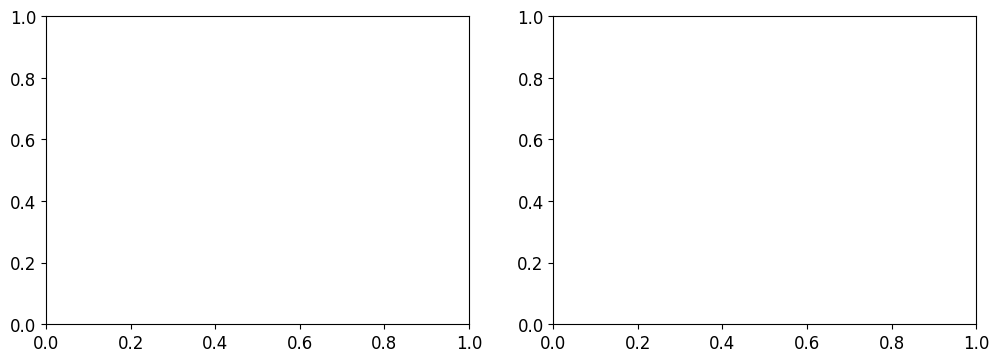

In [2]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

ax = axes[0]
ax.scatter(descriptors_transformed[:,0],
           descriptors_transformed[:,1],s=300,alpha=0.5)

ax.set_aspect('equal')
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_title('Descriptor space (Home-made PCA)')

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
descriptors_transformed_sklearn = sklearn_pca.fit_transform(descriptors_original)
ax = axes[1]
ax.scatter(descriptors_transformed_sklearn[:,0],
           descriptors_transformed_sklearn[:,1],s=300,alpha=0.5,color='C2')

ax.set_aspect('equal')
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_title('Descriptor space (sklearn PCA)')

fig.tight_layout()


### Now rattle one of the structures

In [14]:
def get_rattled_copies_of_atomic_cluster_number(i):
    selected_position = positions_in_file[i]
    new_positions = [selected_position]
    for _ in range(9):
        new_positions += [selected_position + \
                          0.05 * np.random.randn(*selected_position.shape)]
    positions = np.array(new_positions)
    rattled_atomic_clusters = [AtomicCluster(lennard_jones_calc,pos=pos,
                                    descriptor_method=descriptor)\
                for pos in positions]
    return rattled_atomic_clusters

In [15]:
rattled_atomic_clusters = get_rattled_copies_of_atomic_cluster_number(5)

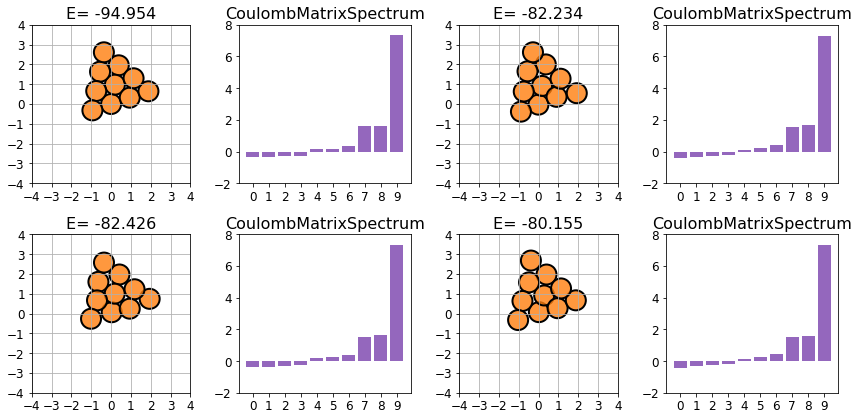

In [16]:
make_plot('exercise_21_fig5.png',rattled_atomic_clusters,color='C1')

### Insert the rattled structure in the PCA plot

In [17]:
descriptors_all = np.array([cluster.descriptor for cluster in atomic_clusters])# + rattled_atomic_clusters])
pca.fit(descriptors_all)
descriptors_transformed_relaxed = pca.transform(np.array([cluster.descriptor for cluster in atomic_clusters]))


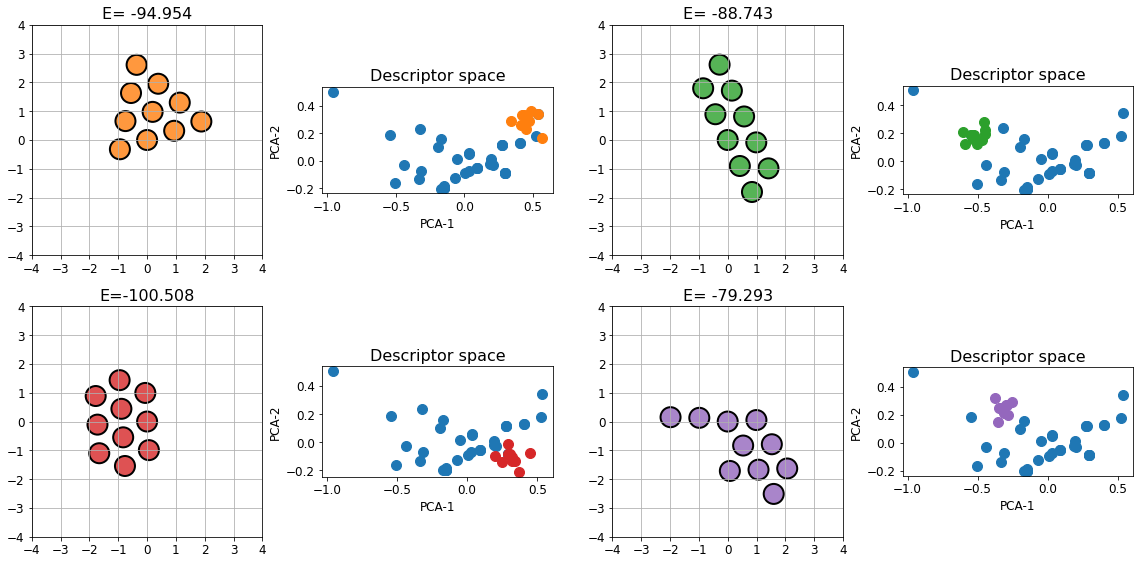

In [18]:
fig, axes = plt.subplots(2,4,figsize=(16,8))
for j,(i,ax) in enumerate(zip([5, 5, 37, 37, 17, 17, 22, 22],axes.ravel())):
    rattled_atomic_clusters = get_rattled_copies_of_atomic_cluster_number(i)
    
    if j%2 == 0:        
        ring_size = 400
        rattled_atomic_clusters[0].draw(ax,ring_size,alpha=0.8,edge=True,color=f'C{j//2+1}')
        
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_aspect('equal')
        ax.set_xlim([-b,b])
        ax.set_ylim([-b,b])
        ax.grid('on')
        continue
        
    ax.scatter(descriptors_transformed_relaxed[:,0],
               descriptors_transformed_relaxed[:,1],s=100)
    
    descriptors_transformed_rattled = \
        pca.transform(np.array([cluster.descriptor for cluster in rattled_atomic_clusters]))
    ax.scatter(descriptors_transformed_rattled[:,0],
               descriptors_transformed_rattled[:,1],s=100,c=f'C{j//2+1}')

    ax.set_aspect('equal')
    ax.set_xlabel('PCA-1')
    ax.set_ylabel('PCA-2')
    ax.set_title('Descriptor space')

fig.tight_layout()
